In [1]:
# Cell 0 — setup
!pip install -q imbalanced-learn shap joblib

import os, sys, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             classification_report, confusion_matrix, accuracy_score,
                             average_precision_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers

import joblib
import shap

sns.set(style="whitegrid")
print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices('GPU')))


TensorFlow: 2.19.0
GPU available: False


In [4]:
# Cell 1 — load dataset (change filename if needed)
DATA_PATH = "/content/compressed_data.csv.gz"  # <-- change if your file name differs
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['SK_ID_CURR'].plot(kind='hist', bins=20, title='SK_ID_CURR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['TARGET'].plot(kind='hist', bins=20, title='TARGET')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['AMT_INCOME_TOTAL'].plot(kind='hist', bins=20, title='AMT_INCOME_TOTAL')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('NAME_CONTRACT_TYPE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('CODE_GENDER').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('FLAG_OWN_CAR').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('FLAG_OWN_REALTY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='SK_ID_CURR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='SK_ID_CURR', y='TARGET', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='TARGET', y='AMT_INCOME_TOTAL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='AMT_INCOME_TOTAL', y='AMT_CREDIT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('NAME_CONTRACT_TYPE')):
  _plot_series(series, series_name, i)
  fig.legend(title='NAME_CONTRACT_TYPE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CODE_GENDER')):
  _plot_series(series, series_name, i)
  fig.legend(title='CODE_GENDER', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('FLAG_OWN_CAR')):
  _plot_series(series, series_name, i)
  fig.legend(title='FLAG_OWN_CAR', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('FLAG_OWN_REALTY')):
  _plot_series(series, series_name, i)
  fig.legend(title='FLAG_OWN_REALTY', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['SK_ID_CURR'].plot(kind='line', figsize=(8, 4), title='SK_ID_CURR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['TARGET'].plot(kind='line', figsize=(8, 4), title='TARGET')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['AMT_INCOME_TOTAL'].plot(kind='line', figsize=(8, 4), title='AMT_INCOME_TOTAL')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CODE_GENDER'].value_counts()
    for x_label, grp in _df_20.groupby('NAME_CONTRACT_TYPE')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('NAME_CONTRACT_TYPE')
_ = plt.ylabel('CODE_GENDER')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['FLAG_OWN_CAR'].value_counts()
    for x_label, grp in _df_21.groupby('CODE_GENDER')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CODE_GENDER')
_ = plt.ylabel('FLAG_OWN_CAR')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['FLAG_OWN_REALTY'].value_counts()
    for x_label, grp in _df_22.groupby('FLAG_OWN_CAR')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('FLAG_OWN_CAR')
_ = plt.ylabel('FLAG_OWN_REALTY')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['NAME_TYPE_SUITE'].value_counts()
    for x_label, grp in _df_23.groupby('FLAG_OWN_REALTY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('FLAG_OWN_REALTY')
_ = plt.ylabel('NAME_TYPE_SUITE')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['NAME_CONTRACT_TYPE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='NAME_CONTRACT_TYPE', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['CODE_GENDER'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='CODE_GENDER', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['FLAG_OWN_CAR'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='FLAG_OWN_CAR', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['FLAG_OWN_REALTY'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='FLAG_OWN_REALTY', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [5]:
# Cell 2 — pick a target column automatically if possible
target_candidates = ['default','is_default','loan_status','loan_default','target','repaid','loan_repaid','outcome']
target_col = None
for c in target_candidates:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    # fallback guesses: common Lending datasets use 'not.fully.paid', 'Status'
    for c in ['not.fully.paid','Status','DEFAULT']:
        if c in df.columns:
            target_col = c
            break

if target_col is None:
    # final fallback — user should edit this variable after reading the warning
    target_col = 'default'
    print(f"WARNING: target not auto-detected. Using '{target_col}'. If incorrect, edit target_col in this cell.")

print("Using target column:", target_col)
print("\nColumn types and missing counts:")
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(20))


Using target column: default

Column types and missing counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

,0
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
COMMONAREA_MEDI,214865
NONLIVINGAPARTMENTS_MEDI,213514
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
FONDKAPREMONT_MODE,210295
LIVINGAPARTMENTS_AVG,210199
LIVINGAPARTMENTS_MEDI,210199
LIVINGAPARTMENTS_MODE,210199


In [7]:
# Cell 3 — target distribution & base stats
target_col = 'TARGET' # Corrected target column

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not in dataframe. Edit target_col to the correct name.")

y_counts = df[target_col].value_counts(dropna=False)
print("Target distribution:\n", y_counts)
if y_counts.shape[0] > 1:
    print("Imbalance ratio (major/minor):", y_counts.max() / y_counts.min())
else:
    print("Target may be single-valued — check dataset.")

display(df.describe(include='all').T)

Target distribution:
 TARGET
0    282686
1     24825
Name: count, dtype: int64
Imbalance ratio (major/minor): 11.387150050352467


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,NaN,NaN,NaN,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,NaN,NaN,NaN,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,307511,3,F,202448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,307511,2,N,202924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,NaN,NaN,NaN,0.007,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,NaN,NaN,NaN,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,NaN,NaN,NaN,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,NaN,NaN,NaN,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


No charts were generated by quickchart


In [8]:
# Cell 4 — identify numeric & categorical columns
df_work = df.copy()

numeric_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_work.select_dtypes(include=['object','category']).columns.tolist()

# remove target if present in lists
if target_col in numeric_cols: numeric_cols.remove(target_col)
if target_col in cat_cols: cat_cols.remove(target_col)

print("Numeric cols:", numeric_cols)
print("Categorical cols (example):", cat_cols[:10])

# Missing % per column
missing_pct = df_work.isnull().mean().sort_values(ascending=False)
display(missing_pct[missing_pct > 0].head(30))


Numeric cols: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', '

,0
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_MODE,0.683550


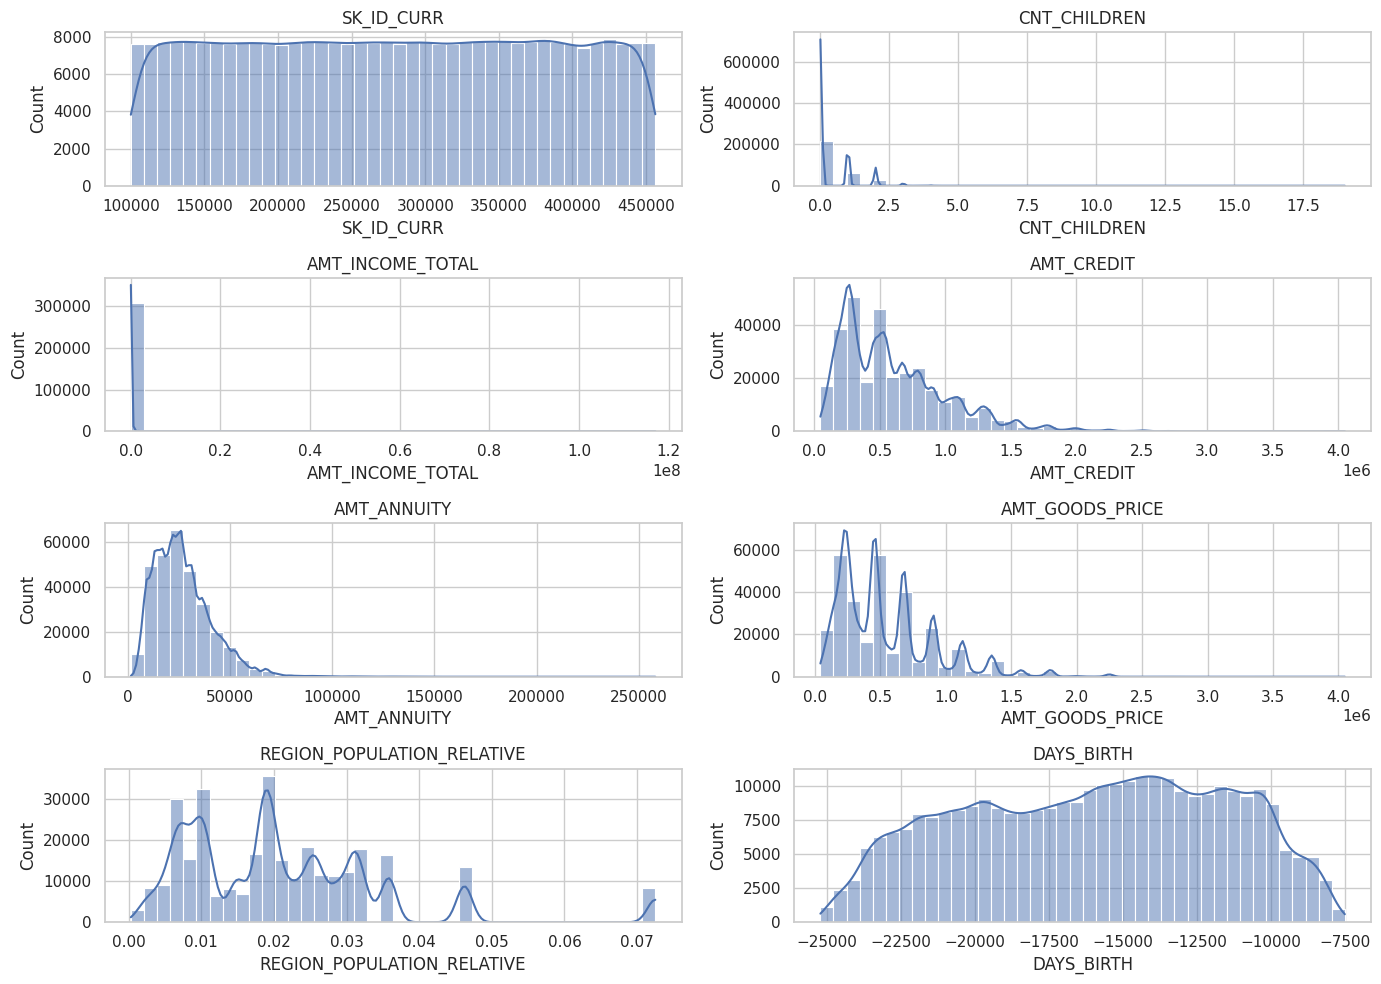

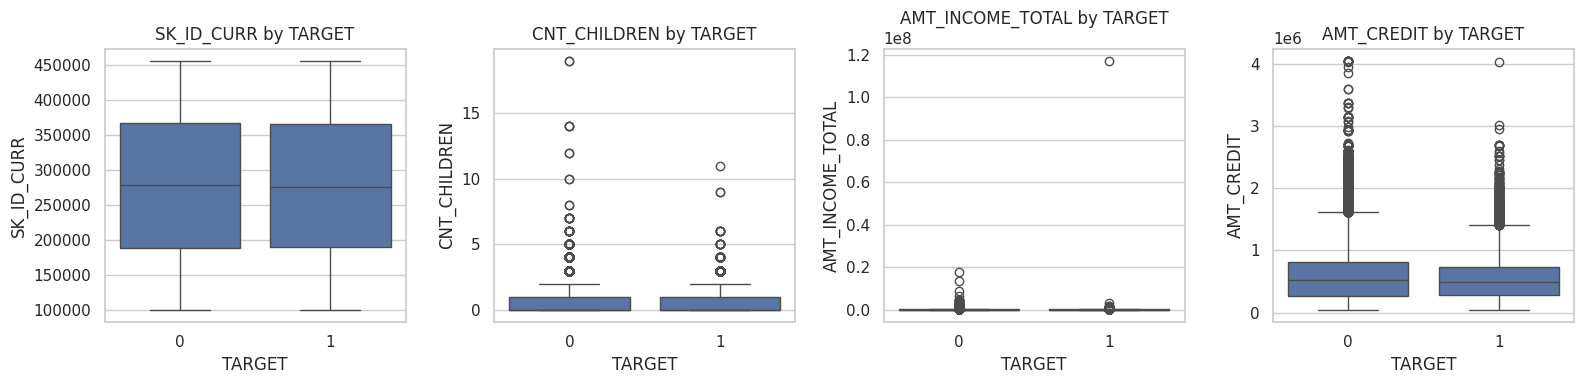

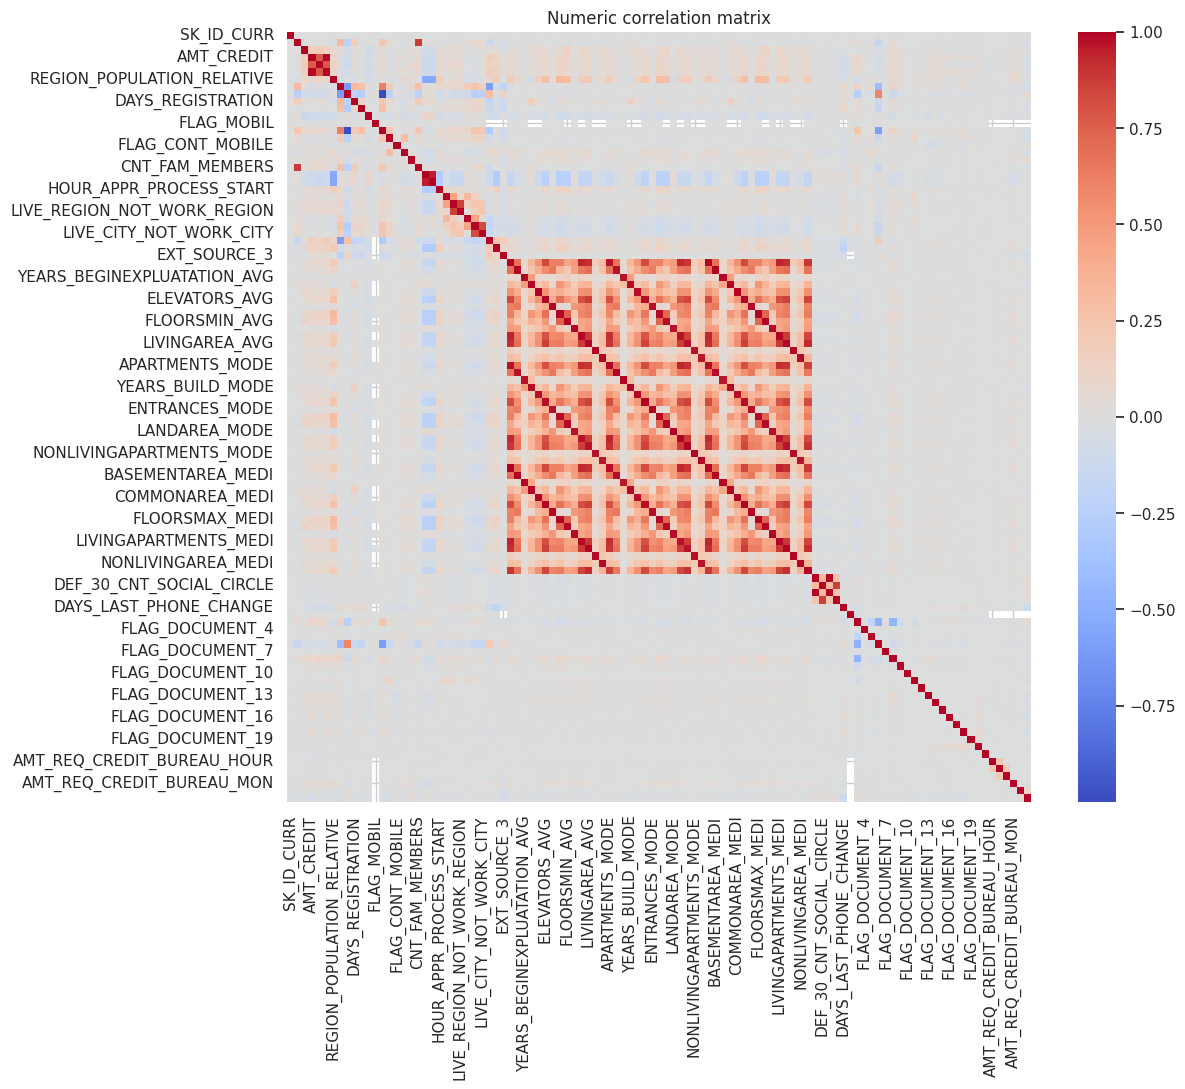

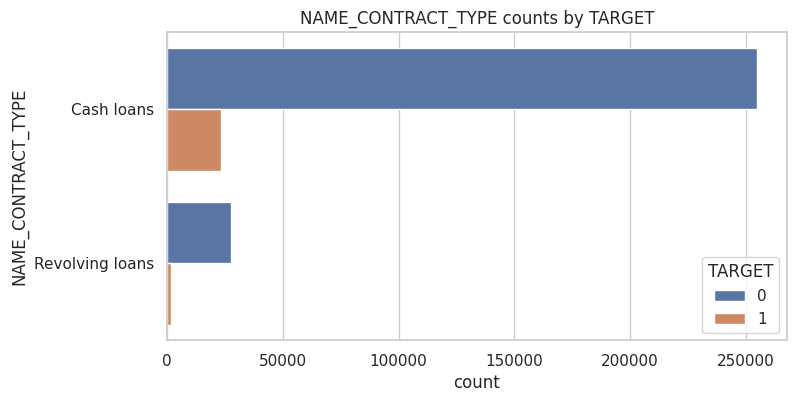

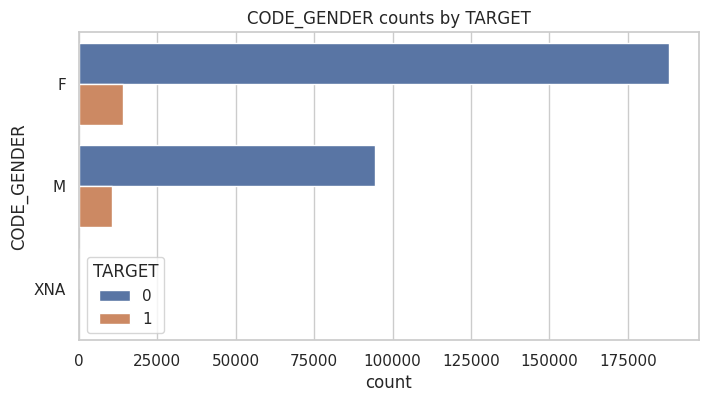

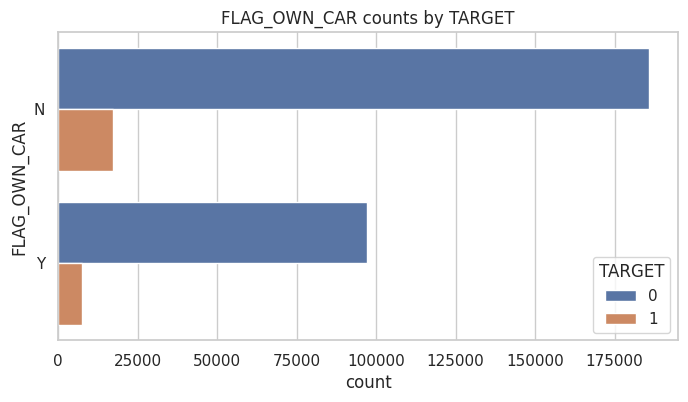

In [9]:
# Cell 5 — EDA plots (numerics + selected categoricals)
# Numeric distributions (first 8)
plot_num = numeric_cols[:8]
plt.figure(figsize=(14,10))
for i, c in enumerate(plot_num,1):
    plt.subplot(4,2,i)
    sns.histplot(df_work[c].dropna(), bins=40, kde=True)
    plt.title(c)
plt.tight_layout(); plt.show()

# Boxplots grouped by target for a few numeric features
plt.figure(figsize=(16,4))
for i, c in enumerate(plot_num[:4],1):
    plt.subplot(1,4,i)
    sns.boxplot(x=df_work[target_col], y=df_work[c])
    plt.title(f"{c} by {target_col}")
plt.tight_layout(); plt.show()

# Heatmap for numeric correlation
plt.figure(figsize=(12,10))
sns.heatmap(df_work[numeric_cols].corr(), cmap='coolwarm', center=0)
plt.title("Numeric correlation matrix"); plt.show()

# Categorical counts for first 3 categorical columns
for c in cat_cols[:3]:
    plt.figure(figsize=(8,4))
    sns.countplot(y=c, hue=target_col, data=df_work, order=df_work[c].value_counts().index)
    plt.title(f"{c} counts by {target_col}")
    plt.show()


In [10]:
# Cell 6 — cleaning strategy
df_clean = df_work.copy()

# Drop rows where target is missing
df_clean = df_clean[~df_clean[target_col].isnull()].copy()

# Drop columns with >50% missing
missing_pct = df_clean.isnull().mean()
drop_cols = missing_pct[missing_pct > 0.5].index.tolist()
if drop_cols:
    print("Dropping columns with >50% missing:", drop_cols)
    df_clean.drop(columns=drop_cols, inplace=True)

# Impute numeric with median, categorical with 'Missing'
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
if target_col in num_cols: num_cols.remove(target_col)
if target_col in cat_cols: cat_cols.remove(target_col)

for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna('Missing')

print("Missing values after imputation:", df_clean.isnull().sum().sum())
print("New shape:", df_clean.shape)


Dropping columns with >50% missing: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']
Missing values after imputation: 0
New shape: (307511, 81)


In [11]:
# Cell 7 — basic feature engineering examples
# Example transforms (comment/uncomment depending on dataset)
df_fe = df_clean.copy()

# If there's an 'annual_income' or 'log_income' column, make both variants
if 'log.annual.inc' in df_fe.columns and 'annual_inc' not in df_fe.columns:
    df_fe['annual_inc'] = np.exp(df_fe['log.annual.inc'].clip(lower=-20, upper=50))

# create years of credit line if days column exists
if 'days.with.cr.line' in df_fe.columns:
    df_fe['years_with_cr'] = (df_fe['days.with.cr.line'] / 365).round(2)

# create debt burden features if revol.util & revol.bal exist
if 'revol.util' in df_fe.columns and 'revol.bal' in df_fe.columns:
    df_fe['rev_util_bal_ratio'] = df_fe['revol.util'] / (1 + df_fe['revol.bal'])

print("Added FE columns if applicable. Columns now:", df_fe.shape[1])
display(df_fe.head())


Added FE columns if applicable. Columns now: 81


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


from matplotlib import pyplot as plt
_df_28['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29['SK_ID_CURR'].plot(kind='hist', bins=20, title='SK_ID_CURR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['TARGET'].plot(kind='hist', bins=20, title='TARGET')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['AMT_INCOME_TOTAL'].plot(kind='hist', bins=20, title='AMT_INCOME_TOTAL')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_32.groupby('NAME_CONTRACT_TYPE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_33.groupby('CODE_GENDER').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_34.groupby('FLAG_OWN_CAR').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_35.groupby('FLAG_OWN_REALTY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36.plot(kind='scatter', x='index', y='SK_ID_CURR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37.plot(kind='scatter', x='SK_ID_CURR', y='TARGET', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_38.plot(kind='scatter', x='TARGET', y='AMT_INCOME_TOTAL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_39.plot(kind='scatter', x='AMT_INCOME_TOTAL', y='AMT_CREDIT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_40.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('NAME_CONTRACT_TYPE')):
  _plot_series(series, series_name, i)
  fig.legend(title='NAME_CONTRACT_TYPE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_41.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CODE_GENDER')):
  _plot_series(series, series_name, i)
  fig.legend(title='CODE_GENDER', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_42.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('FLAG_OWN_CAR')):
  _plot_series(series, series_name, i)
  fig.legend(title='FLAG_OWN_CAR', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['TARGET']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_43.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('FLAG_OWN_REALTY')):
  _plot_series(series, series_name, i)
  fig.legend(title='FLAG_OWN_REALTY', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('TARGET')

from matplotlib import pyplot as plt
_df_44['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_45['SK_ID_CURR'].plot(kind='line', figsize=(8, 4), title='SK_ID_CURR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_46['TARGET'].plot(kind='line', figsize=(8, 4), title='TARGET')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_47['AMT_INCOME_TOTAL'].plot(kind='line', figsize=(8, 4), title='AMT_INCOME_TOTAL')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CODE_GENDER'].value_counts()
    for x_label, grp in _df_48.groupby('NAME_CONTRACT_TYPE')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('NAME_CONTRACT_TYPE')
_ = plt.ylabel('CODE_GENDER')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['FLAG_OWN_CAR'].value_counts()
    for x_label, grp in _df_49.groupby('CODE_GENDER')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CODE_GENDER')
_ = plt.ylabel('FLAG_OWN_CAR')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['FLAG_OWN_REALTY'].value_counts()
    for x_label, grp in _df_50.groupby('FLAG_OWN_CAR')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('FLAG_OWN_CAR')
_ = plt.ylabel('FLAG_OWN_REALTY')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['NAME_TYPE_SUITE'].value_counts()
    for x_label, grp in _df_51.groupby('FLAG_OWN_REALTY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('FLAG_OWN_REALTY')
_ = plt.ylabel('NAME_TYPE_SUITE')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_52['NAME_CONTRACT_TYPE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_52, x='index', y='NAME_CONTRACT_TYPE', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_53['CODE_GENDER'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_53, x='index', y='CODE_GENDER', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_54['FLAG_OWN_CAR'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_54, x='index', y='FLAG_OWN_CAR', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_55['FLAG_OWN_REALTY'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_55, x='index', y='FLAG_OWN_REALTY', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [12]:
# Cell 8 — drop highly correlated numeric features
num_cols_fe = df_fe.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols_fe: num_cols_fe.remove(target_col)

corr = df_fe[num_cols_fe].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print("Dropping due to corr >", threshold, ":", to_drop)

df_reduced = df_fe.drop(columns=to_drop)
print("Shape after drop:", df_reduced.shape)


Dropping due to corr > 0.85 : ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
Shape after drop: (307511, 70)


In [14]:
# Cell 9 — build preprocessor
features = df_reduced.drop(columns=[target_col])
target = df_reduced[target_col].astype(int)

num_cols = features.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = features.select_dtypes(include=['object','category']).columns.tolist()

# choose categorical columns to One-Hot (<=20 unique)
cat_ohe = [c for c in cat_cols if features[c].nunique() <= 20]
cat_high = [c for c in cat_cols if features[c].nunique() > 20]
print("OHE cols:", cat_ohe)
print("High-cardinality (left as ordinal):", cat_high)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_ohe),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_high)
], remainder='drop')

# fit preprocessor
preprocessor.fit(features)
X_all = preprocessor.transform(features)
print("Transformed shape:", X_all.shape)

OHE cols: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'EMERGENCYSTATE_MODE']
High-cardinality (left as ordinal): ['ORGANIZATION_TYPE']
Transformed shape: (307511, 128)


In [15]:
# Cell 10 — split and handle imbalance
X = X_all
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train / Test:", X_train.shape, X_test.shape)
print("Train class dist:", np.bincount(y_train))

# class weights
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {int(c): w for c, w in zip(classes, cw)}
print("Class weights:", class_weights)

# Optional: SMOTE (disabled by default)
use_smote = False
if use_smote:
    print("Applying SMOTE...")
    sm = SMOTE(random_state=42, n_jobs=-1)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print("After SMOTE:", X_train.shape, np.bincount(y_train))


Train / Test: (246008, 128) (61503, 128)
Train class dist: [226148  19860]
Class weights: {0: np.float64(0.5439092983356032), 1: np.float64(6.193554884189325)}


In [16]:
# Cell 11 — model definition
input_dim = X_train.shape[1]
def build_model(input_dim, lr=1e-3, dropout=0.3):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.AUC(name='auc')])
    return model

model = build_model(input_dim)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,033 (297.00 KB)

 Trainable params: 75,137 (293.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [17]:
# Cell 12 — training
EPOCHS = 50
BATCH = 512

es = callbacks.EarlyStopping(monitor='val_auc', patience=6, mode='max', restore_best_weights=True)
rlp = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, mode='max', min_lr=1e-6)

history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    class_weight=class_weights,
                    callbacks=[es, rlp],
                    verbose=2)


Epoch 1/50
409/409 - 18s - 45ms/step - accuracy: 0.6006 - auc: 0.6606 - loss: 0.6819 - val_accuracy: 0.6906 - val_auc: 0.7332 - val_loss: 0.5769 - learning_rate: 1.0000e-03
Epoch 2/50
409/409 - 16s - 39ms/step - accuracy: 0.6518 - auc: 0.7181 - loss: 0.6203 - val_accuracy: 0.6447 - val_auc: 0.7397 - val_loss: 0.6317 - learning_rate: 1.0000e-03
Epoch 3/50
409/409 - 11s - 26ms/step - accuracy: 0.6641 - auc: 0.7280 - loss: 0.6101 - val_accuracy: 0.7006 - val_auc: 0.7389 - val_loss: 0.5729 - learning_rate: 1.0000e-03
Epoch 4/50
409/409 - 11s - 26ms/step - accuracy: 0.6640 - auc: 0.7322 - loss: 0.6066 - val_accuracy: 0.6644 - val_auc: 0.7395 - val_loss: 0.6050 - learning_rate: 1.0000e-03
Epoch 5/50
409/409 - 10s - 25ms/step - accuracy: 0.6646 - auc: 0.7349 - loss: 0.6043 - val_accuracy: 0.7208 - val_auc: 0.7384 - val_loss: 0.5511 - learning_rate: 1.0000e-03
Epoch 6/50
409/409 - 6s - 15ms/step - accuracy: 0.6683 - auc: 0.7374 - loss: 0.6019 - val_accuracy: 0.6863 - val_auc: 0.7407 - val_loss

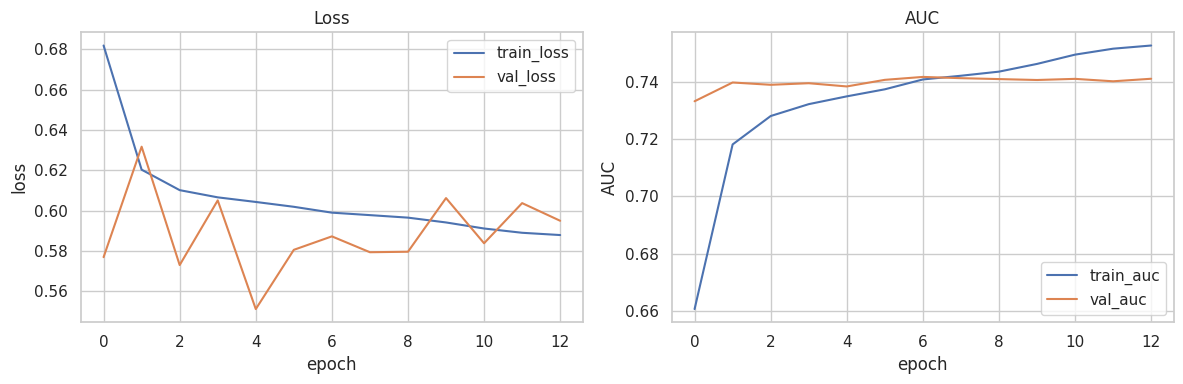

In [18]:
# Cell 13 — training curves
h = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(h['loss'], label='train_loss'); plt.plot(h['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(h['auc'], label='train_auc'); plt.plot(h['val_auc'], label='val_auc')
plt.xlabel('epoch'); plt.ylabel('AUC'); plt.legend(); plt.title('AUC')
plt.tight_layout(); plt.show()


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Accuracy: 0.6732517112986358
ROC AUC: 0.7414348581141248
Average Precision (PR AUC): 0.21811347988512605
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.67      0.79     56538
           1       0.16      0.69      0.25      4965

    accuracy                           0.67     61503
   macro avg       0.56      0.68      0.52     61503
weighted avg       0.90      0.67      0.75     61503



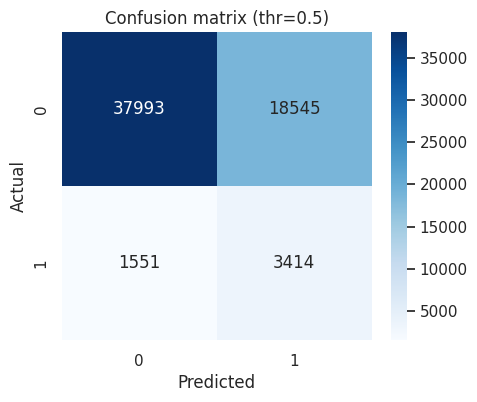

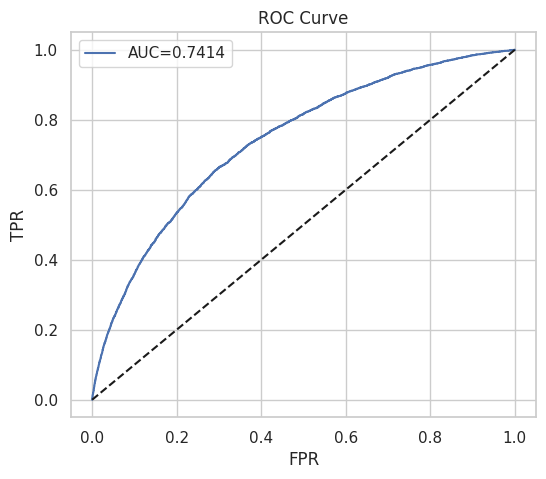

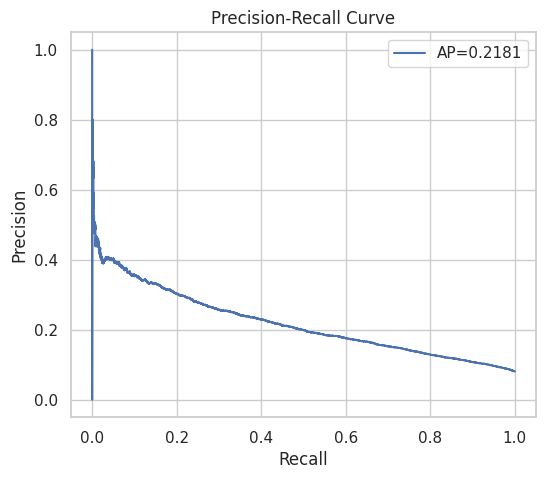

In [19]:
# Cell 14 — evaluate
y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Average Precision (PR AUC):", average_precision_score(y_test, y_proba))
print("Classification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title('Confusion matrix (thr=0.5)')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_test,y_proba):.4f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5)); plt.plot(rec, prec, label=f"AP={average_precision_score(y_test,y_proba):.4f}")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.show()


Best F1: 0.2915619920200975 at threshold 0.66
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56538
           1       0.23      0.40      0.29      4965

    accuracy                           0.84     61503
   macro avg       0.59      0.64      0.60     61503
weighted avg       0.89      0.84      0.86     61503



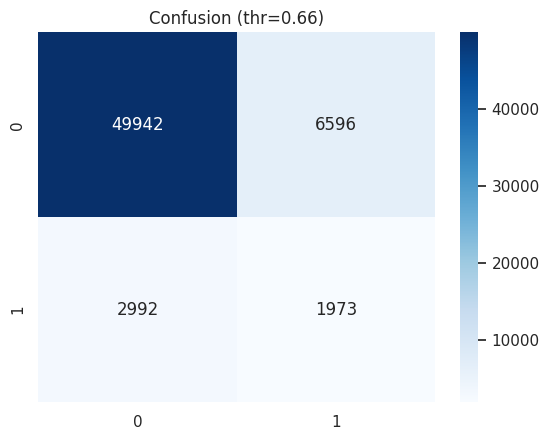

In [20]:
# Cell 15 — find best threshold by F1
best_f1, best_t = 0, 0.5
for t in np.linspace(0.01,0.99,99):
    preds = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t
print("Best F1:", best_f1, "at threshold", best_t)

# Show confusion at best threshold
best_preds = (y_proba >= best_t).astype(int)
print(classification_report(y_test, best_preds))
sns.heatmap(confusion_matrix(y_test, best_preds), annot=True, fmt='d', cmap='Blues'); plt.title(f'Confusion (thr={best_t:.2f})'); plt.show()


In [21]:
# Cell 16 — save artifacts
MODEL_FILE = "house_loan_model.h5"
PREPROC_FILE = "house_preprocessor.pkl"
model.save(MODEL_FILE)
joblib.dump(preprocessor, PREPROC_FILE)
print("Saved model:", MODEL_FILE)
print("Saved preprocessor:", PREPROC_FILE)


Saved model: house_loan_model.h5
Saved preprocessor: house_preprocessor.pkl


SHAP computed. Plotting summary...


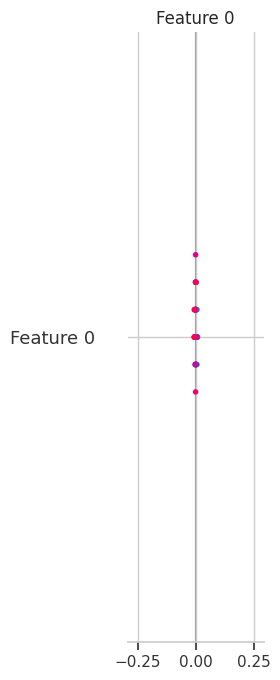

In [22]:
# Cell 17 — SHAP explainability (sample to speed-up)
# NOTE: For large input dims, KernelExplainer can be slow. We'll use a small sample and DeepExplainer for TF nets.
explainer = None
try:
    # Use a small background sample
    background = X_train[np.random.choice(X_train.shape[0], min(200, X_train.shape[0]), replace=False)]
    test_sample = X_test[np.random.choice(X_test.shape[0], min(100, X_test.shape[0])), :]
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(test_sample)
    print("SHAP computed. Plotting summary...")
    shap.summary_plot(shap_values, test_sample, plot_type="bar")
except Exception as e:
    print("SHAP explanation failed (possibly due to size). Error:", e)
    print("You can run SHAP locally with smaller samples.")


In [23]:
# Cell 18 — predict on new rows (example)
# Replace sample_rows with actual new data frame matching original columns
sample_rows = df_reduced.drop(columns=[target_col]).head(3)
X_sample = preprocessor.transform(sample_rows)
probs = model.predict(X_sample).ravel()
for i, p in enumerate(probs):
    print(f"Row {i} probability of default: {p:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Row 0 probability of default: 0.8903
Row 1 probability of default: 0.1891
Row 2 probability of default: 0.1870
